In [54]:
import numpy as np
import pandas as pd
import networkx as nx

np.random.seed(0)


## Create Supply Chain Snapshots for the years 2020-2023

In [ ]:
# Define oil and gas NACE4 lists
oil_nace4_list = [4671, 4730, 610, 1920]
gas_nace4_list = [3521, 3522, 3521]
electricity_nace4_list = [3511, 3512, 3513, 3514]


# Create firm list (12 firms)
n = 12
firm_list = pd.DataFrame({
    'id': range(1, n + 1),
    'nace4': [1920, 3523, 3511, 141, 146, 721, 729, 1711, 1712, 2529, 2573, 2599],

})

# Add NACE2 column
firm_list['nace2'] = firm_list['nace4'] // 100

# Function to create energy purchases snapshot for a given year
def create_snapshot(year):
    G = nx.DiGraph()
    # Add nodes with firm information
    for _, row in firm_list.iterrows():
        G.add_node(row['id'], nace4=row['nace4'], nace2=row['nace2'])

    edges = []
    
    # Create edges for the snapshot
    for firm_id in range(4, n + 1):
        edges.append((2, firm_id, np.random.randint(10**5, 5*10**5)))  # Link to gas
        edges.append((3, firm_id, np.random.randint(10**5, 5*10**5)))  # Link to electricity

    # Oil-Dependent Firms (Firm 4-6) - Stronger link to oil
    for firm_id in range(4, 7):
        edges.append((1, firm_id, np.random.randint(6*10**6, 9*10**6)))  # Stronger link to oil

    # Gas-Dependent Firms (Firm 7-9) - Stronger link to gas, with random growth over time
    for firm_id in range(7, 10):
        initial_link = np.random.randint(6*10**6, 9*10**6)
        increment = np.random.randint(5,10) / 100  # Random increase between 5% and 10%
        new_link = int(initial_link * (1 + increment))  # Apply random increase to link strength
        edges.append((2, firm_id, new_link))

    # Electricity-Dependent Firms (Firm 10-12) - Stronger link to electricity, with random growth over time
    for firm_id in range(10, 13):
        initial_link = np.random.randint(6*10**6, 9*10**6)
        increment = np.random.randint(5,10) / 100  # Random increase between 5% and 10%
        new_link = int(initial_link * (1 + increment))  # Apply random increase to link strength
        edges.append((3, firm_id, new_link))

    # Add edges to the graph
    for edge in edges:
        G.add_edge(edge[0], edge[1], weight=edge[2])

    return G

# Create 4 snapshots with random increases
snapshots = []

for year in range(2020,2024):  # Create 4 snapshots
    snapshots.append(create_snapshot(year))

## Plot Supply Chain Snapshots

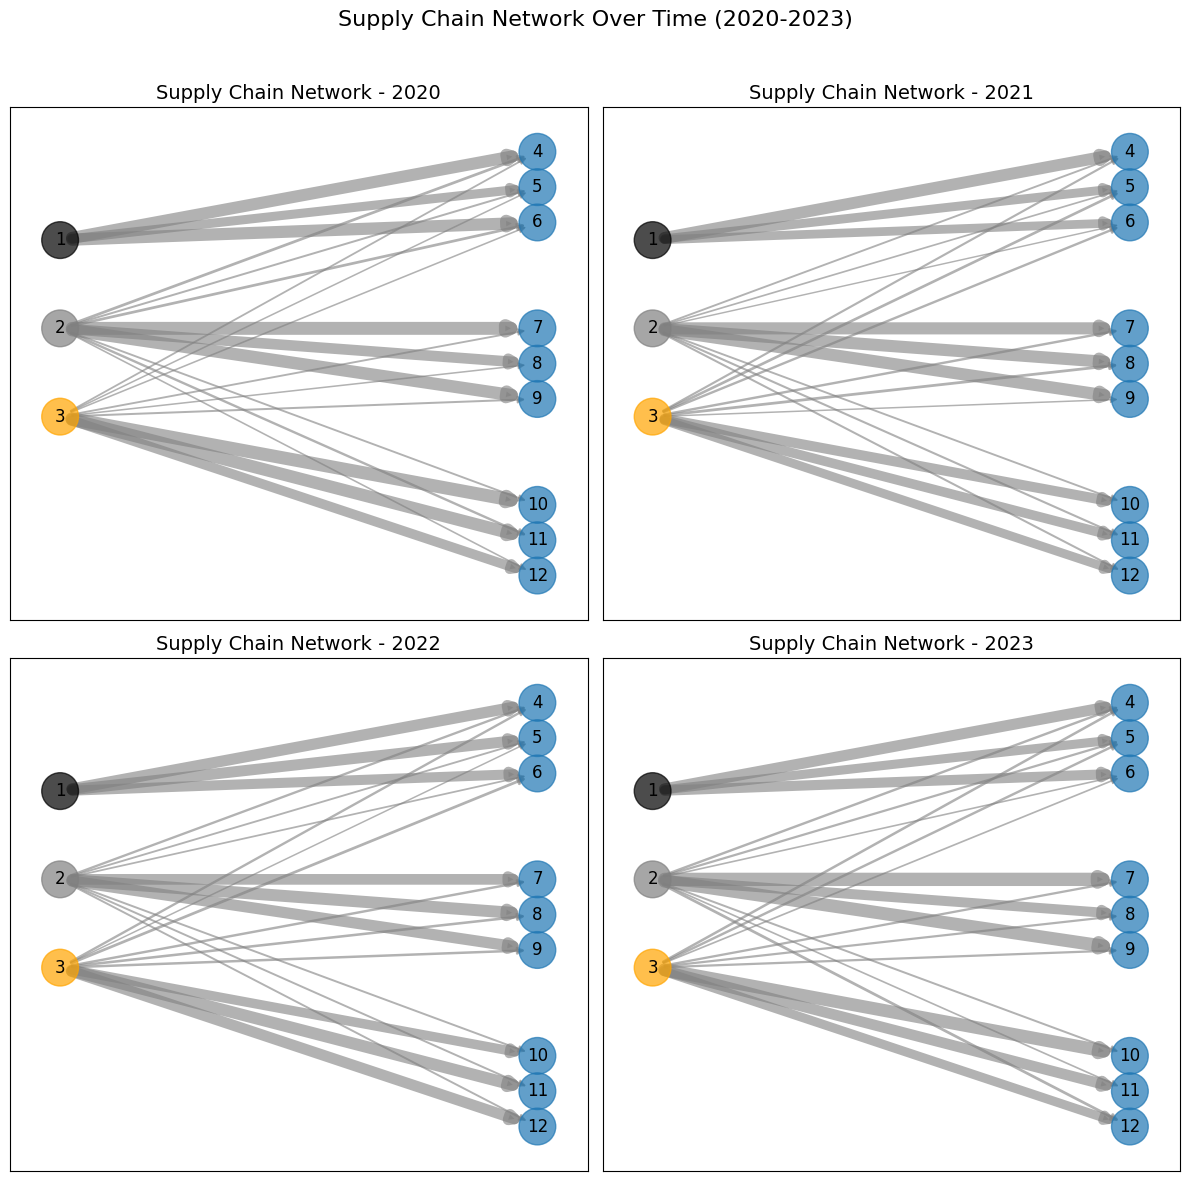

In [56]:
np.random.seed(0)

# Initialize figure with subplots for 4 years
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Initialize pos as an empty dictionary
pos = {}

# Update positions for specific nodes
pos[1] = [-0.5, 0.5]  # Energy provider - oil
pos[2] = [-0.5, 0]    # Energy provider - gas
pos[3] = [-0.5, -0.5] # Energy provider - electricity

# Assign positions to oil dependent firms
for i, node in enumerate([4, 5, 6]):
    pos[node] = [0.5, 1 - i * 0.2]

# Assign positions to gas dependent firms
for i, node in enumerate([7, 8, 9]):
    pos[node] = [0.5, 0 - i * 0.2]

# Assign positions to electricity dependent firms
for i, node in enumerate([10, 11, 12]):
    pos[node] = [0.5, -1 - i * 0.2]

# Colors for energy providers in the original code
def get_node_color(node):
    if node == 1:
        return 'black'  # oil provider
    elif node == 2:
        return 'gray'   # gas provider
    elif node == 3:
        return 'orange' # electricity provider
    else:
        return 'tab:blue'  # other firms

# Loop through the snapshots (2020-2023) and plot each in separate subplots
for idx, snapshot in enumerate(snapshots):
    ax = axs[idx // 2, idx % 2]  # Determine the correct subplot (2x2 grid)
    
    # nodes
    node_colors = [get_node_color(node) for node in snapshot.nodes()]
    nx.draw_networkx_nodes(snapshot, pos, node_size=700, node_color=node_colors, alpha=0.7, ax=ax)
    
    # edges
    weights = [d['weight'] / 10**6 for (u, v, d) in snapshot.edges(data=True)]
    nx.draw_networkx_edges(snapshot, pos, edgelist=snapshot.edges(), width=weights, alpha=0.6, edge_color='gray', ax=ax)
    
    # labels
    nx.draw_networkx_labels(snapshot, pos, font_size=12, font_family="sans-serif", ax=ax)
    
    # Add title for each subplot
    ax.set_title(f"Supply Chain Network - {2020 + idx}", fontsize=14)

# Add a general title
fig.suptitle("Supply Chain Network Over Time (2020-2023)", fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Aggregate Energy Purchases of Firms

In [57]:

# Function to aggregate the purchases for each year
def aggregate_purchases():
    years = [2020, 2021, 2022, 2023]
    
    # Initialize an empty dictionary to store the purchases data
    purchases_dict = {
        'firm_id': list(range(1, n + 1)),  # Firm IDs
    }
    
    # Iterate through each year and aggregate the purchases
    for year in years:
        G = create_snapshot(year)

        # Aggregate purchases data for each firm
        for firm_id in range(1, n + 1):
            oil_purchases = 0
            gas_purchases = 0
            electricity_purchases = 0

            # Get the link weights for this firm
            for provider in G.predecessors(firm_id):  # For each provider (edges coming into firm)
                link_weight = G[provider][firm_id]['weight']

                # Check the type of provider (oil, gas, or electricity)
                if provider == 1:  # Oil provider
                    oil_purchases += link_weight
                elif provider == 2:  # Gas provider
                    gas_purchases += link_weight
                elif provider == 3:  # Electricity provider
                    electricity_purchases += link_weight

            # Add the purchases data to the corresponding year column
            purchases_dict[f'oil_purchases_{year}'] = purchases_dict.get(f'oil_purchases_{year}', []) + [oil_purchases]
            purchases_dict[f'gas_purchases_{year}'] = purchases_dict.get(f'gas_purchases_{year}', []) + [gas_purchases]
            purchases_dict[f'electricity_purchases_{year}'] = purchases_dict.get(f'electricity_purchases_{year}', []) + [electricity_purchases]
    
    # Convert the dictionary to a DataFrame
    purchases_df = pd.DataFrame(purchases_dict)

    return purchases_df

# Get the aggregated purchases for all firms over the years
df_purchases = aggregate_purchases()


### Add synthetic revenue and employment data for each firm for each year

### REVENUE DATA
# Base revenue for each firm between 10**8 and 10**11 HUF
base_revenue = np.random.randint(10**8, 10**11, size=len(df_purchases),dtype=np.int64)

# Apply slight random variations for each year
revenue_2021 = base_revenue * np.random.uniform(0.95, 1.05, len(df_purchases))
revenue_2022 = revenue_2021 * np.random.uniform(0.95, 1.05, len(df_purchases))
revenue_2023 = revenue_2022 * np.random.uniform(0.95, 1.05, len(df_purchases))

# Add the revenue columns to the dataframe
df_purchases['revenue_2020'] = base_revenue
df_purchases['revenue_2021'] = revenue_2021
df_purchases['revenue_2022'] = revenue_2022
df_purchases['revenue_2023'] = revenue_2023

df_purchases["nace2"] = firm_list["nace2"]
df_purchases["nace4"] = firm_list["nace4"]
df_parent_nace = pd.read_csv("data/nace_parent.csv")
nace_parent_dict = dict(zip(df_parent_nace["nace"], df_parent_nace["parent_nace"]))
df_purchases["parent_nace"] = df_purchases["nace2"].map(nace_parent_dict)

### EMPLOYMENT DATA
# Base employment for each firm between 5 and 500 employees
base_employment = np.random.randint(5, 501, size=len(df_purchases))

# Apply slight random variations for each year
employment_2021 = base_employment * np.random.uniform(0.95, 1.05, len(df_purchases))
employment_2022 = employment_2021 * np.random.uniform(0.95, 1.05, len(df_purchases))
employment_2023 = employment_2022 * np.random.uniform(0.95, 1.05, len(df_purchases))

# Round employment to whole numbers
employment_2021 = np.round(employment_2021).astype(int)
employment_2022 = np.round(employment_2022).astype(int)
employment_2023 = np.round(employment_2023).astype(int)

# Add the employment columns to the dataframe
df_purchases['employment_2020'] = base_employment
df_purchases['employment_2021'] = employment_2021
df_purchases['employment_2022'] = employment_2022
df_purchases['employment_2023'] = employment_2023

df_purchases

,firm_id,oil_purchases_2020,gas_purchases_2020,electricity_purchases_2020,oil_purchases_2021,gas_purchases_2021,electricity_purchases_2021,oil_purchases_2022,gas_purchases_2022,electricity_purchases_2022,...,revenue_2021,revenue_2022,revenue_2023,nace2,nace4,parent_nace,employment_2020,employment_2021,employment_2022,employment_2023
0,1,0,0,0,0,0,0,0,0,0,...,6.299407e+10,6.546063e+10,6.650583e+10,19,1920,C,212,211,218,226
1,2,0,0,0,0,0,0,0,0,0,...,8.421950e+10,8.573592e+10,8.602062e+10,35,3523,D,272,283,273,286
2,3,0,0,0,0,0,0,0,0,0,...,7.861968e+10,7.822027e+10,7.611249e+10,35,3511,D,171,169,171,177
3,4,8701626,1985772,1305711,8534258,1370648,1556209,8071492,1684007,1716713,...,5.848928e+10,6.128841e+10,6.064408e+10,1,141,A,116,115,111,106
4,5,6541377,1435829,1117952,6410807,1230131,1918301,7917999,1354361,1080163,...,2.141925e+10,2.059719e+10,2.084190e+10,1,146,A,354,368,381,375
5,6,8771495,1963395,1152315,6320290,1049811,1724115,7259508,1274278,1978039,...,9.791254e+10,1.005270e+11,1.002744e+11,7,721,B,134,138,142,146
6,7,0,9314719,1359783,0,8738048,1745895,0,7705163,1762286,...,3.653671e+10,3.621453e+10,3.610636e+10,7,729,B,228,233,234,227
7,8,0,7645272,1122579,0,8716563,1999361,0,8612025,1849792,...,9.194254e+09,9.355557e+09,9.557706e+09,17,1711,C,379,364,360,361
8,9,0,8958366,1448242,0,8743178,1084665,0,8090775,1796213,...,7.373739e+10,7.189245e+10,7.036826e+10,17,1712,C,305,318,304,291
9,10,0,1374564,9398847,0,1381567,7245707,0,1412556,6827602,...,9.483656e+10,9.306518e+10,9.198062e+10,25,2529,C,221,226,230,223


In [58]:
df_purchases.to_csv("data/energy_purchases_revenue_firms_2020-2023.csv", index = False)